# ML-Based Marketing

Руководитель: [Лукьянченко Пётр Павлович](https://www.hse.ru/staff/lukianchenko)

Студенты: [Гончаров Фёдор Михайлович](http://t.me/fmgoncharov), [Писцов Георгий Константинович](http://t.me/GoshaNice)

Материалы:
- [КТ1](https://drive.google.com/file/d/1X9sN0MSib5yEGM-PElc6Y33UsGcLC2Nz/view?usp=share_link)
- [CausalML](https://github.com/uber/causalml)
- [EconlML](https://github.com/py-why/EconML)

## Первичная подготовка данных

Импортируем все необходимые библиотеки

In [1]:
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv

Загружаем датасеты за 3 месяца

In [2]:
jan2feb = pd.read_csv('jan2feb.csv', sep=';', parse_dates=['Дата'], dayfirst=True).iloc[::-1]
feb2mar = pd.read_csv('feb2mar.csv', sep=';', parse_dates=['Дата'], dayfirst=True).iloc[::-1]
mar2apr = pd.read_csv('mar2apr.csv', sep=';', parse_dates=['Дата'], dayfirst=True).iloc[::-1]

Объединяем три месяца в один датасет, выставляем даты транзакций как индексы, убираем колонку с уникальными номерами заказов

In [5]:
df = pd.concat([jan2feb, feb2mar, mar2apr], ignore_index=True, verify_integrity=True)
df.rename(columns={"Дата": "Date", "Профиль участника": "UID", "Вид операции": "OperationType", "Сумма": "Price", "Сумма списанных монет": "SpentCoins", "Сумма начисленных монет": "GainedCoins", "Ресторан": "Point", "Агент продаж": "Agent", "Статус": "Status"}, inplace=True)
df.set_index('Date', inplace=True)
df.drop(columns=['Номер'], inplace=True)
df.head()

,UID,OperationType,Price,SpentCoins,GainedCoins,Point,Agent,Status
Date,,,,,,,,
2023-01-15 00:06:45,37704f27-3e29-11eb-80c2-00155d01af05,Покупка,127.0,37.0,2.54,Р АЭРОПОРТ,Касса,Бронзовый ключ
2023-01-15 00:12:34,0ca8729c-f364-11ea-80e4-f403435823a3,Покупка,105.0,NaN,2.10,Р АЭРОПОРТ,Касса,Бронзовый ключ
2023-01-15 00:22:00,b152cb7e-de6e-11ec-80dc-00155dd23e20,Покупка,551.0,9.0,16.53,Р АЭРОПОРТ,Касса,Серебряный ключ
2023-01-15 00:34:51,0ca8729c-f364-11ea-80e4-f403435823a3,Покупка,113.0,NaN,2.26,Р АЭРОПОРТ,Касса,Бронзовый ключ
2023-01-15 00:36:00,b152cb7e-de6e-11ec-80dc-00155dd23e20,Покупка,280.0,NaN,8.40,Р АЭРОПОРТ,Касса,Серебряный ключ


In [6]:
day_of_week_labels = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
months_labels = ['Январь', 'Февраль', 'Май', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
assert(len(day_of_week_labels) == 7 and len(months_labels) == 12)

start_dt, end_dt = df.iloc[0].name, df.iloc[-1].name
print(f'Датасет начинается {start_dt.day} {months_labels[start_dt.month-1][:-1]}я и заканчивается {end_dt.day} {months_labels[end_dt.month-1][:-1]}я включительно')

Датасет начинается 15 Января и заканчивается 14 Апреля включительно


Проверяем размер данных

In [7]:
m, n = df.shape
numerical = ['Price', 'SpentCoins', 'GainedCoins', 'ActualPrice']
categorical = ['OperationType', 'Point', 'Agent', 'Status']
print(f"В датасете {m} строк и {n} столбцов")
print(f"Из них {len(numerical)} численных и {len(categorical)} категориальных")
assert(len(numerical) + len(categorical) == n)

В датасете 2267437 строк и 8 столбцов
Из них 4 численных и 4 категориальных


Заполняем пропуски по потраченным и начисленным монетам. Делаем колонку по процент накопления монет по статусу

In [8]:
cols_with_nans = []
for col in df:
    if df[col].isna().sum() > 0:
        cols_with_nans.append(col)
        df[col].fillna(0, inplace=True)
print("Найдены пропуски в колонках", *cols_with_nans)
print("Пропуски заполнены нулями")

df['Discount'] = df['Status'].replace({"Бронзовый ключ": 0.02, "Серебряный ключ": 0.03, "Золотой ключ": 0.05, "Платиновый ключ": 0.07, "Сотрудник": 0.15})

Найдены пропуски в колонках SpentCoins GainedCoins
Пропуски заполнены нулями


In [9]:
assert(len(df.groupby('UID')['Status'].nunique().unique()) > 1)
print("Статусы соответсвуют дню совершения транзакции")

Статусы соответсвуют дню совершения транзакции


Добавляем технические переменные о датах совершения транзакции

In [10]:
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Hour'] = df.index.hour
df['DayOfYear'] = df.index.dayofyear

Начинаем собирать данные по клиентам. Начинаем с последнего статуса, далее оценим покупательскую активность по RFM-анализу

In [11]:
clients = df.groupby('UID').Status.last().to_frame()

In [13]:
clients['FavouriteDay'] = df.groupby(['UID', 'DayOfWeek']).Price.mean().to_frame().reset_index().sort_values(by = ['UID', 'Price'], ascending=False).groupby('UID').DayOfWeek.first()

### Воздействие $T_1$ - Переход на новый статус лояльности

В последствии в нашем датасете клиентов мы будем называть его TreatmentStatus

In [14]:
hierarchy = {"Бронзовый ключ": 0, "Серебряный ключ": 1, "Золотой ключ": 2, "Платиновый ключ": 3, "Сотрудник": 4}
df['StatusNew'] = df["Status"].apply(lambda x: hierarchy[x])

In [15]:
middle_data = df.loc['2023-02-15':'2023-03-15'].groupby('UID').StatusNew
clients['TreatmentStatus'] = (middle_data.is_monotonic_increasing) & (middle_data.nunique() > 1)

In [16]:
clients['TreatmentStatus'].fillna(value = False, inplace = True)
clients['TreatmentStatus'] = clients['TreatmentStatus'].astype(int)
clients

,Status,Recency,FavouriteDay,TreatmentStatus
UID,,,,
00004b3d-550c-11ec-80da-00155dd23e20,Бронзовый ключ,98,5,0
0000582d-3d6f-11ed-80df-00155dd23e20,Платиновый ключ,83,6,0
000058d5-6d87-11ed-80e2-00155dd23e20,Платиновый ключ,100,4,0
00005d8b-08e4-11ed-80dd-00155dd23e20,Бронзовый ключ,50,4,0
0000bc9f-3799-11ea-80d4-f403433ddaaf,Серебряный ключ,101,1,0
...,...,...,...,...
ffff9419-16cf-11ec-80d8-00155dd23e20,Серебряный ключ,41,4,0
ffffa515-53b1-11ed-80e0-00155dd23e20,Бронзовый ключ,53,2,0
ffffac76-619a-11ed-80e1-00155dd23e20,Серебряный ключ,26,6,0


Проверяю, что это вообще работает

In [17]:
df[df['UID'] == '0019e1b8-f6e0-11ec-80dd-00155dd23e20']

,UID,OperationType,Price,SpentCoins,GainedCoins,Point,Agent,Status,Discount,DayOfWeek,Month,Hour,DayOfYear,StatusNew
Date,,,,,,,,,,,,,,
2023-01-28 17:37:40,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,691.0,0.0,13.82,Р Город Лефортово,Касса,Бронзовый ключ,0.02,5,1,17,28,0
2023-01-29 13:31:35,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,889.0,0.0,26.67,Р Павелецкая Плаза,Касса,Серебряный ключ,0.03,6,1,13,29,1
2023-02-14 15:00:32,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,453.0,0.0,13.59,Р Никольская,Касса,Серебряный ключ,0.03,1,2,15,45,1
2023-02-14 15:01:54,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,325.0,0.0,9.75,Р Никольская,Касса,Серебряный ключ,0.03,1,2,15,45,1
2023-02-14 15:04:08,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,1.0,214.0,0.03,Р Никольская,Касса,Серебряный ключ,0.03,1,2,15,45,1
2023-03-11 18:02:40,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,1385.0,0.0,41.55,Р Авиа Парк,Касса,Серебряный ключ,0.03,5,3,18,70,1
2023-03-12 15:24:52,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,227.0,0.0,11.35,Р Город Лефортово,Касса,Золотой ключ,0.05,6,3,15,71,2


### Воздействие $T_2$ - Использование баллов Спасибо

**Рассуждения**

$round((price - sber) * discount, 2) = gained\_coins$

По правилам округления до сотых делаем оценку

$(price - sber) * discount = gained\_coins \pm 0.005$

$price - sber = \frac{gained\_coins \pm 0.005}{discount}$

$sber = price - \frac{gained\_coins \pm 0.005}{discount}$

$sber = price - \frac{gained\_coins}{discount} \pm \frac{0.005}{discount}$

Оцениваем $\frac{0.005}{discount}$ по максимально возможному значению скидки $0.02: \frac{0.005}{0.02} = 0.25$

Значит, во всех транзакциях, где полученный $sber$ больше 0.25 мы имели дело с реальным использованием баллов Спасибо

**Вывод**

Для надёжности и логичности введём порог на воздействие с помощью баллов Спасибо в размере 10 рублей

In [18]:
df['SberSpasibo'] = 0
df.loc[df.Price - df.GainedCoins / df.Discount > 10, 'SberSpasibo'] = 1
clients['SberSpasibo'] = df.groupby('UID').SberSpasibo.any()

## Целевая переменная Y(Эксперимент с causes and outcomes)

### Запускать только в случае если это нужно

In [20]:
clients['Recency'] = df.loc[:'2023-02-15'].groupby('UID').DayOfYear.max()
clients['Frequency'] = df.loc[:'2023-02-15'].groupby('UID').Price.count()
clients['Monetary_Sum'] = df.loc[:'2023-02-15'].groupby('UID').Price.sum()
clients['Monetary_Mean'] = df.loc[:'2023-02-15'].groupby('UID').Price.mean()


In [21]:
clients['outcome'] = df.loc['2023-03-15':].groupby('UID').Price.sum()
clients['outcome'].fillna(0, inplace=True)
clients.dropna(inplace=True)
print(clients.shape)

(265169, 9)


Импортирую функции

In [23]:
import causalml
from causalml.metrics import plot_qini, qini_score
from causalml.inference.tree import CausalRandomForestRegressor, CausalTreeRegressor

## Эксперименты с Causes/Outcome

In [24]:
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

from causalml.metrics import *

feature_names = ['Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Mean'] 
X, y, treatment = clients[feature_names + ['FavouriteDay', 'SberSpasibo']], clients['outcome'], clients['TreatmentStatus']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['FavouriteDay', 'SberSpasibo']),
    ('scaling', StandardScaler(),feature_names),
])

X = column_transformer.fit_transform(X)


### MetaLearners CatBoost

In [ ]:
!pip install catboost

In [47]:
import catboost
from catboost import CatBoostRegressor

In [48]:
best_params['S_CatBoost'] = {'iterations': 0, 'depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=64) as pbar:
    for iterations in [100, 200, 400, 600]:
        for depth in [2, 4, 8, 16]:
            for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
                learner_s_catboost = BaseSRegressor(learner=CatBoostRegressor(iterations = iterations, 
                                                                        depth = depth, 
                                                                        learning_rate = lr, verbose=False))
                cate_s_catboost = learner_s_catboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
                df_preds_catboost = pd.DataFrame([
                                   cate_s_catboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['S CatBoost','w','y']).T
                cur_qini = get_qini(df_preds_catboost).sum(axis=0)['S CatBoost']
                if cur_qini > best_qini:
                    best_params['S_CatBoost']['iterations'] = iterations
                    best_params['S_CatBoost']['depth'] = depth
                    best_params['S_CatBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for S_CatBoost:')
print(best_params['S_CatBoost'])

100%|███████████████████████████████████████████| 64/64 [22:25<00:00, 21.02s/it]

Best parameters for S_CatBoost:
{'iterations': 600, 'depth': 16, 'lr': 0.1}


In [49]:
best_params['T_CatBoost'] = {'iterations': 0, 'depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=64) as pbar:
    for iterations in [100, 200, 400, 600]:
        for depth in [2, 4, 8, 16]:
            for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
                learner_t_catboost = BaseTRegressor(learner=CatBoostRegressor(iterations = iterations, 
                                                                        depth = depth, 
                                                                        learning_rate = lr, verbose=False))
                cate_t_catboost = learner_t_catboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
                df_preds_catboost = pd.DataFrame([
                                   cate_t_catboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['T CatBoost','w','y']).T
                cur_qini = get_qini(df_preds_catboost).sum(axis=0)['T CatBoost']
                if cur_qini > best_qini:
                    best_params['T_CatBoost']['iterations'] = iterations
                    best_params['T_CatBoost']['depth'] = depth
                    best_params['T_CatBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for T_CatBoost:')
print(best_params['T_CatBoost'])

100%|███████████████████████████████████████████| 64/64 [34:46<00:00, 32.60s/it]

Best parameters for T_CatBoost:
{'iterations': 600, 'depth': 16, 'lr': 0.1}


In [50]:
best_params['X_CatBoost'] = {'iterations': 0, 'depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=64) as pbar:
    for iterations in [100, 200, 400, 600]:
        for depth in [2, 4, 8, 16]:
            for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
                learner_x_catboost = BaseXRegressor(learner=CatBoostRegressor(iterations = iterations, 
                                                                        depth = depth, 
                                                                        learning_rate = lr, verbose=False))
                cate_x_catboost = learner_x_catboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
                df_preds_catboost = pd.DataFrame([
                                   cate_x_catboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['X CatBoost','w','y']).T
                cur_qini = get_qini(df_preds_catboost).sum(axis=0)['X CatBoost']
                if cur_qini > best_qini:
                    best_params['X_CatBoost']['iterations'] = iterations
                    best_params['X_CatBoost']['depth'] = depth
                    best_params['X_CatBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for X_CatBoost:')
print(best_params['X_CatBoost'])

100%|████████████████████████████████████████| 64/64 [3:42:33<00:00, 208.65s/it]

Best parameters for X_CatBoost:
{'iterations': 600, 'depth': 16, 'lr': 0.1}


In [51]:
# S Learner with CatBoost
learner_s_catboost = BaseSRegressor(learner=CatBoostRegressor(iterations = best_params['S_CatBoost']['iterations'], 
                                                              depth = best_params['S_CatBoost']['depth'], 
                                                              learning_rate = best_params['S_CatBoost']['lr'], verbose=False))
cate_s_catboost = learner_s_catboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('S Learner on CatBoost is fitted')

# T Learner with CatBoost
learner_t_catboost = BaseTRegressor(learner=CatBoostRegressor(iterations = best_params['T_CatBoost']['iterations'], 
                                                              depth = best_params['T_CatBoost']['depth'], 
                                                              learning_rate = best_params['T_CatBoost']['lr'], verbose=False))
cate_t_catboost = learner_t_catboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('T Learner on CatBoost is fitted')

# X Learner with CatBoost
learner_x_catboost = BaseXRegressor(learner=CatBoostRegressor(iterations = best_params['X_CatBoost']['iterations'], 
                                                              depth = best_params['X_CatBoost']['depth'], 
                                                              learning_rate = best_params['X_CatBoost']['lr'], verbose=False))
cate_x_catboost = learner_x_catboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('X Learner on CatBoost is fitted')

S Learner on CatBoost is fitted
T Learner on CatBoost is fitted
X Learner on CatBoost is fitted


In [52]:
df_preds_catboost = pd.DataFrame([cate_s_catboost.ravel(),
                               cate_t_catboost.ravel(),
                               cate_x_catboost.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['S CatBoost','T CatBoost','X CatBoost','w','y']).T

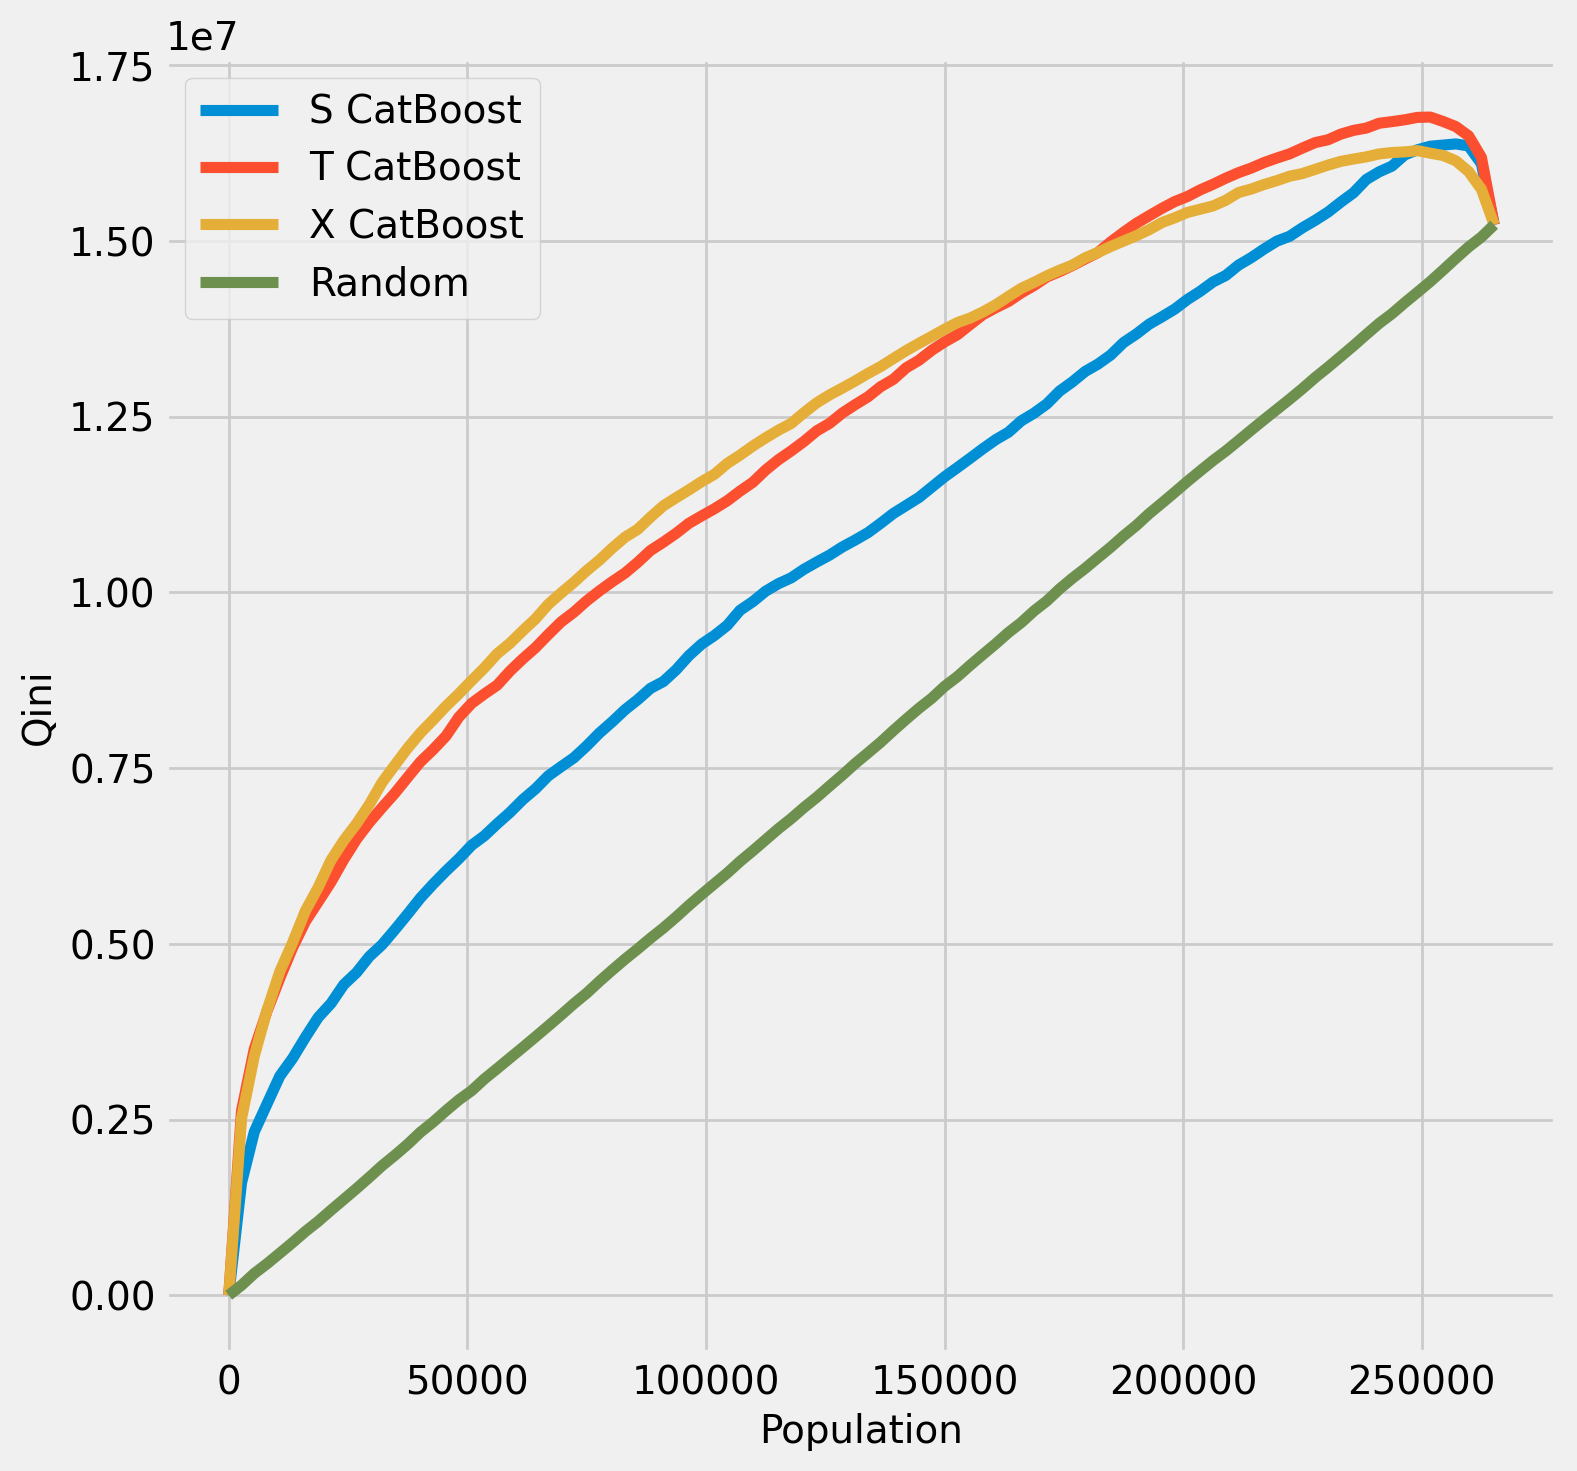

In [53]:
plot_qini(df_preds_catboost)

### MetaLearners XGBoost

In [26]:
from tqdm import tqdm
best_params = {}

In [28]:
# S Learner with XGBoost searching hyperparameters

best_params['S_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_s_xgboost = BaseSRegressor(learner=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                cate_s_xgboost = learner_s_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
                df_preds_xgboost = pd.DataFrame([
                                   cate_s_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['S Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['S Xgboost']
                if cur_qini > best_qini:
                    best_params['S_XGBoost']['n_estimators'] = n_estimators
                    best_params['S_XGBoost']['max_depth'] = max_depth
                    best_params['S_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for S_XGBoost:')
print(best_params['S_XGBoost'])

100%|████████████████████████████████████████| 27/27 [1:18:30<00:00, 174.47s/it]

Best parameters for S_XGBoost:
{'n_estimators': 400, 'max_depth': 40, 'lr': 0.01}


In [29]:
# T Learner with XGBoost searching hyperparameters

best_params['T_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_t_xgboost = BaseTRegressor(learner=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                cate_t_xgboost = learner_t_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
                df_preds_xgboost = pd.DataFrame([
                                   cate_t_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['T Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['T Xgboost']
                if cur_qini > best_qini:
                    best_params['T_XGBoost']['n_estimators'] = n_estimators
                    best_params['T_XGBoost']['max_depth'] = max_depth
                    best_params['T_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)

print('Best parameters for T_XGBoost:')
print(best_params['T_XGBoost'])

100%|████████████████████████████████████████| 27/27 [1:15:23<00:00, 167.52s/it]

Best parameters for T_XGBoost:
{'n_estimators': 200, 'max_depth': 40, 'lr': 0.01}


In [27]:
# X Learner with XGBoost searching hyperparameters               

best_params['X_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_x_xgboost = BaseXRegressor(learner=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                cate_x_xgboost = learner_x_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
                df_preds_xgboost = pd.DataFrame([
                                   cate_x_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['X Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['X Xgboost']
                if cur_qini > best_qini:
                    best_params['X_XGBoost']['n_estimators'] = n_estimators
                    best_params['X_XGBoost']['max_depth'] = max_depth
                    best_params['X_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)

print('Best parameters for X_XGBoost:')
print(best_params['X_XGBoost'])

100%|████████████████████████████████████████| 27/27 [3:43:38<00:00, 496.99s/it]

Best parameters for X_XGBoost:
{'n_estimators': 600, 'max_depth': 40, 'lr': 0.001}


In [30]:
best_params

{'X_XGBoost': {'n_estimators': 600, 'max_depth': 40, 'lr': 0.001},
 'S_XGBoost': {'n_estimators': 400, 'max_depth': 40, 'lr': 0.01},
 'T_XGBoost': {'n_estimators': 200, 'max_depth': 40, 'lr': 0.01}}

In [31]:
# S Learner with XGBoost
learner_s_xgboost = BaseSRegressor(learner=XGBRegressor(n_estimators = best_params['S_XGBoost']['n_estimators'], 
                                                        max_depth = best_params['S_XGBoost']['max_depth'], 
                                                        learning_rate = best_params['S_XGBoost']['lr']))
cate_s_xgboost = learner_s_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('S Learner on XGBoost is fitted')

# T Learner with XGBoost
learner_t_xgboost = BaseTRegressor(learner=XGBRegressor(n_estimators = best_params['T_XGBoost']['n_estimators'], 
                                                        max_depth = best_params['T_XGBoost']['max_depth'], 
                                                        learning_rate = best_params['T_XGBoost']['lr']))
cate_t_xgboost = learner_t_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('T Learner on XGBoost is fitted')

# X Learner with XGBoost
learner_x_xgboost = BaseXRegressor(learner=XGBRegressor(n_estimators = best_params['X_XGBoost']['n_estimators'], 
                                                        max_depth = best_params['X_XGBoost']['max_depth'], 
                                                        learning_rate = best_params['X_XGBoost']['lr']))
cate_x_xgboost = learner_x_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('X Learner on XGBoost is fitted')


S Learner on XGBoost is fitted
T Learner on XGBoost is fitted
X Learner on XGBoost is fitted


In [32]:
df_preds_xgboost = pd.DataFrame([cate_s_xgboost.ravel(),
                               cate_t_xgboost.ravel(),
                               cate_x_xgboost.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['S Xgboost','T Xgboost','X Xgboost','w','y']).T

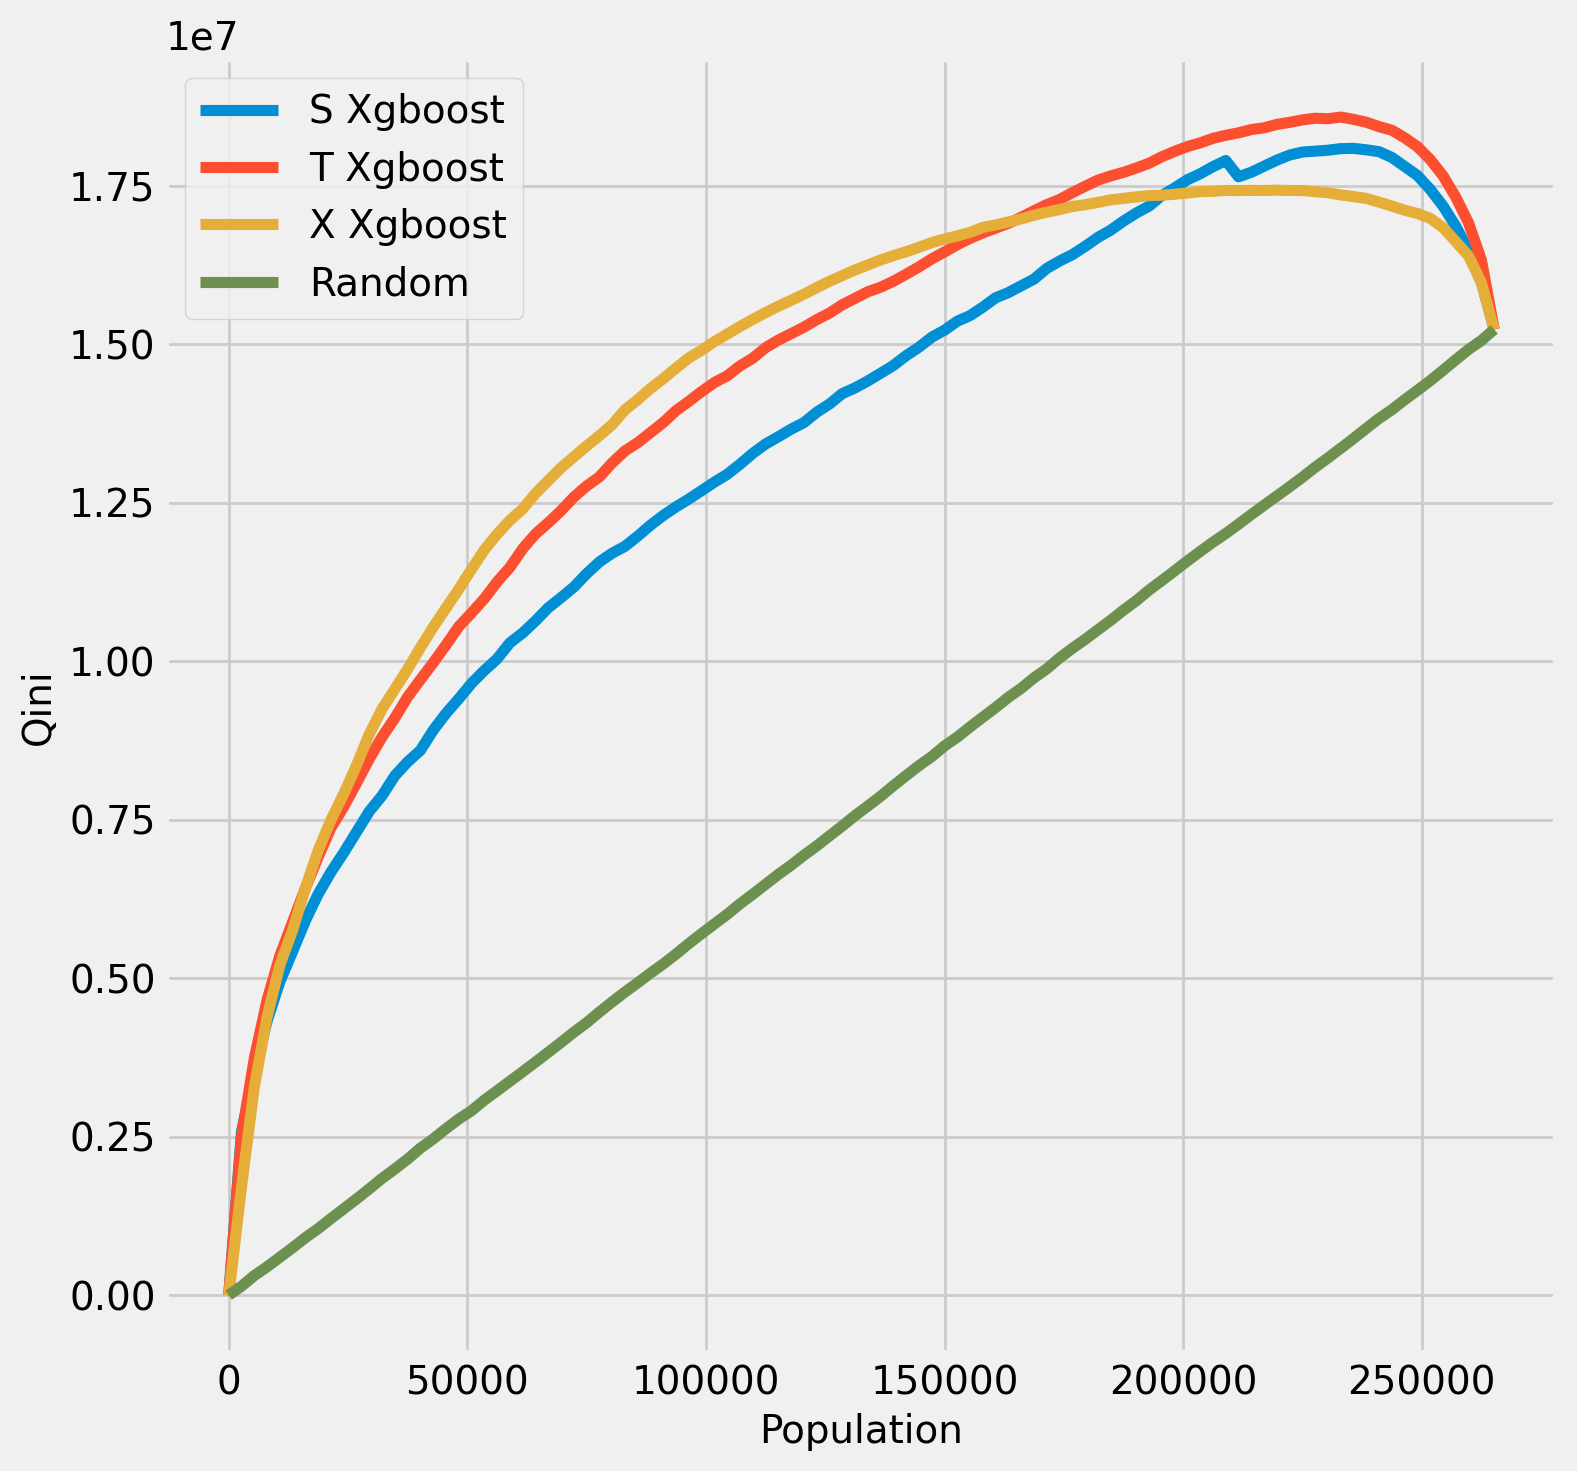

In [33]:
plot_qini(df_preds_xgboost)

### MetaLearners MLP

In [34]:
from sklearn.neural_network import MLPRegressor

# S Learner with MLP searching hyperparameters

best_params['S_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_s_mlp = BaseSRegressor(learner=MLPRegressor(hidden_layer_sizes = hls))
        cate_s_mlp = learner_s_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
        df_preds_mlp = pd.DataFrame([
                           cate_s_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['S MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['S MLP']
        if cur_qini > best_qini:
            best_params['S_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for S_MLP:')
print(best_params['S_MLP'])

100%|████████████████████████████████████████████| 6/6 [29:22<00:00, 293.83s/it]

Best parameters for S_MLP:
{'hls': [300, 300]}


In [35]:
from sklearn.neural_network import MLPRegressor

# S Learner with MLP searching hyperparameters

best_params['T_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_t_mlp = BaseTRegressor(learner=MLPRegressor(hidden_layer_sizes = hls))
        cate_t_mlp = learner_t_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
        df_preds_mlp = pd.DataFrame([
                           cate_t_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['T MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['T MLP']
        if cur_qini > best_qini:
            best_params['T_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for T_MLP:')
print(best_params['T_MLP'])

100%|████████████████████████████████████████████| 6/6 [27:24<00:00, 274.16s/it]

Best parameters for T_MLP:
{'hls': [100]}


In [36]:
from sklearn.neural_network import MLPRegressor

# S Learner with MLP searching hyperparameters

best_params['X_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_x_mlp = BaseXRegressor(learner=MLPRegressor(hidden_layer_sizes = hls))
        cate_x_mlp = learner_x_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
        df_preds_mlp = pd.DataFrame([
                           cate_x_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['X MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['X MLP']
        if cur_qini > best_qini:
            best_params['X_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for X_MLP:')
print(best_params['X_MLP'])

100%|██████████████████████████████████████████| 6/6 [1:09:29<00:00, 694.99s/it]

Best parameters for X_MLP:
{'hls': [200, 200]}


In [37]:
from sklearn.neural_network import MLPRegressor

# S Learner with MLP
learner_s_mlp = BaseSRegressor(learner=MLPRegressor(hidden_layer_sizes = best_params['S_MLP']['hls']))
cate_s_mlp = learner_s_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('S Learner on MLPRegressor is fitted')

# T Learner with MLP
learner_t_mlp = BaseTRegressor(learner=MLPRegressor(hidden_layer_sizes = best_params['T_MLP']['hls']))
cate_t_mlp = learner_t_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('T Learner on MLPRegressor is fitted')

# X Learner with MLP
learner_x_mlp = BaseXRegressor(learner=MLPRegressor(hidden_layer_sizes = best_params['X_MLP']['hls']))
cate_x_mlp = learner_x_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('X Learner on MLPRegressor is fitted')

S Learner on MLPRegressor is fitted
T Learner on MLPRegressor is fitted
X Learner on MLPRegressor is fitted


In [38]:
df_preds_mlp = pd.DataFrame([  cate_s_mlp.ravel(),
                               cate_t_mlp.ravel(),
                               cate_x_mlp.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['S MLP','T MLP','X MLP','w','y']).T


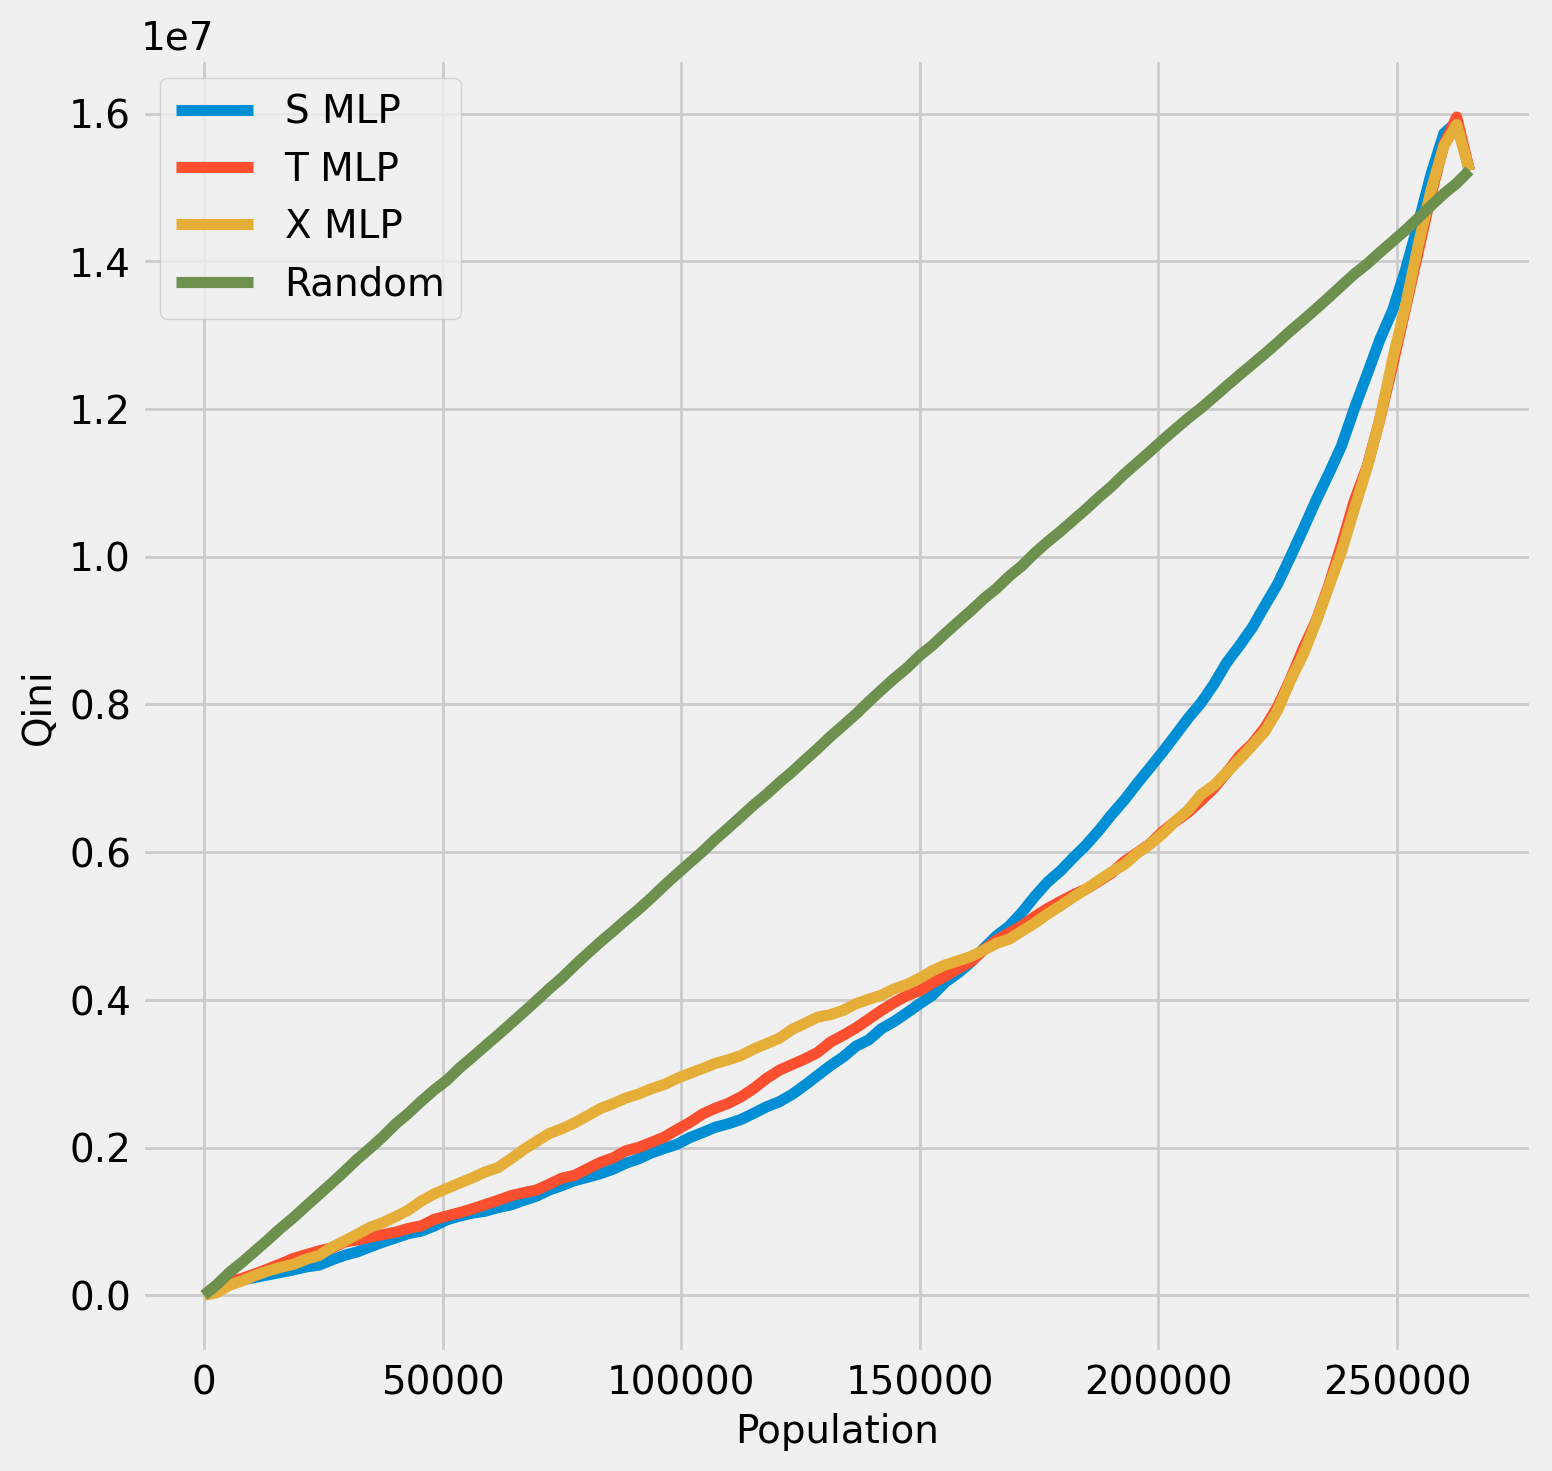

In [39]:
plot_qini(df_preds_mlp)

### CTS

In [40]:
from causalml.inference.tree import CausalRandomForestRegressor, CausalTreeRegressor

In [41]:
from causalml.inference.tree import CausalRandomForestRegressor, CausalTreeRegressor

best_params['CTS'] = {'max_depth': 0}
best_qini = 0
with tqdm(total=4) as pbar:
    for max_depth in [5, 10, 20, 40]:
        ctree = CausalTreeRegressor(max_depth=max_depth)
        cate_tree = ctree.fit_predict(X=X, y=y.values, treatment=treatment.values)
        df_preds_cts = pd.DataFrame([
                           cate_tree.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['CTS','w','y']).T
        cur_qini = get_qini(df_preds_cts).sum(axis=0)['CTS']
        if cur_qini > best_qini:
            best_params['CTS']['max_depth'] = max_depth
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for CTS:')
print(best_params['CTS'])

100%|████████████████████████████████████████████| 4/4 [07:48<00:00, 117.16s/it]

Best parameters for CTS:
{'max_depth': 40}


In [42]:
best_params['CTS_forest'] = {'max_depth': 0, 'n_estimators': 0}
best_qini = 0
with tqdm(total=12) as pbar:
    for max_depth in [5, 10, 20, 40]:
        for n_estimators in [10, 20, 40]:
            cforest = CausalRandomForestRegressor(max_depth = max_depth, n_estimators=n_estimators, n_jobs=5)
            #cateаforest = cforest.fit_predict(X=X, y=y.values, treatment=treatment.values)
            cate_forest = cforest.fit(X=X, y=y.values, treatment=treatment.values).predict(X=X)
            df_preds_forest = pd.DataFrame([
                               cate_forest.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['CTS_forest','w','y']).T
            cur_qini = get_qini(df_preds_forest).sum(axis=0)['CTS_forest']
            if cur_qini > best_qini:
                best_params['CTS_forest']['max_depth'] = max_depth
                best_params['CTS_forest']['n_estimators'] = n_estimators
                best_qini = cur_qini
            pbar.update(1)


                
print('Best parameters for CTS_forest:')
print(best_params['CTS_forest'])

100%|████████████████████████████████████████| 12/12 [2:08:10<00:00, 640.87s/it]

Best parameters for CTS_forest:
{'max_depth': 40, 'n_estimators': 10}


In [43]:
best_params

{'X_XGBoost': {'n_estimators': 600, 'max_depth': 40, 'lr': 0.001},
 'S_XGBoost': {'n_estimators': 400, 'max_depth': 40, 'lr': 0.01},
 'T_XGBoost': {'n_estimators': 200, 'max_depth': 40, 'lr': 0.01},
 'S_MLP': {'hls': [300, 300]},
 'T_MLP': {'hls': [100]},
 'X_MLP': {'hls': [200, 200]},
 'CTS': {'max_depth': 40},
 'CTS_forest': {'max_depth': 40, 'n_estimators': 10}}

In [44]:
ctree = CausalTreeRegressor(max_depth=best_params['CTS']['max_depth'])
cate_tree = ctree.fit_predict(X=X, y=y.values, treatment=treatment.values)

print('CTS fitted')

cforest = CausalRandomForestRegressor(max_depth = best_params['CTS_forest']['max_depth'], n_estimators=best_params['CTS_forest']['n_estimators'], n_jobs=5)
cate_forest = cforest.fit(X=X, y=y.values, treatment=treatment.values).predict(X=X)

print('CTS_forest is fitted')

CTS fitted
CTS_forest is fitted


In [45]:
df_preds_cts = pd.DataFrame([  cate_tree.ravel(),
                               cate_forest.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['CTS','CTS forest','w','y']).T

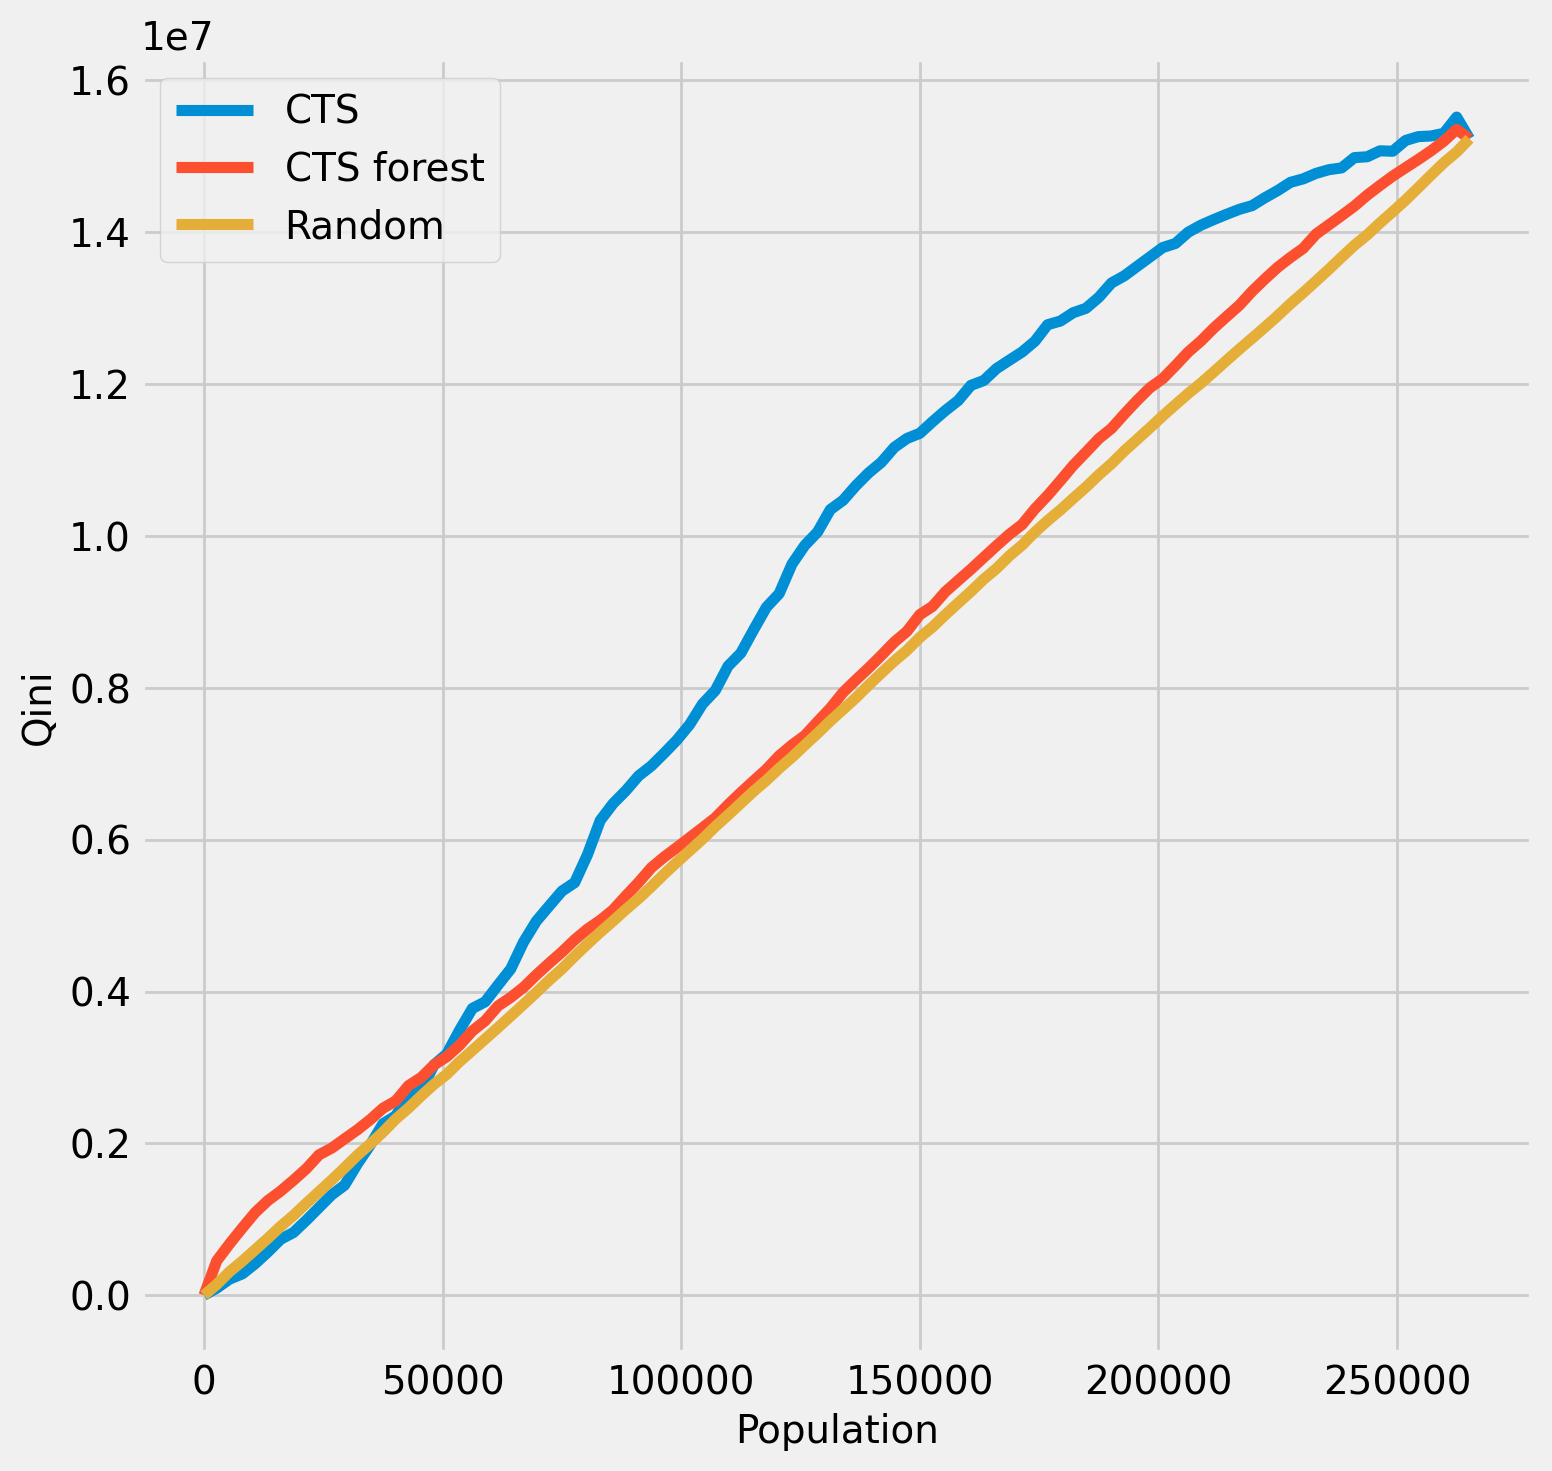

In [46]:
plot_qini(df_preds_cts)

In [54]:
best_params

{'X_XGBoost': {'n_estimators': 600, 'max_depth': 40, 'lr': 0.001},
 'S_XGBoost': {'n_estimators': 400, 'max_depth': 40, 'lr': 0.01},
 'T_XGBoost': {'n_estimators': 200, 'max_depth': 40, 'lr': 0.01},
 'S_MLP': {'hls': [300, 300]},
 'T_MLP': {'hls': [100]},
 'X_MLP': {'hls': [200, 200]},
 'CTS': {'max_depth': 40},
 'CTS_forest': {'max_depth': 40, 'n_estimators': 10},
 'S_CatBoost': {'iterations': 600, 'depth': 16, 'lr': 0.1},
 'T_CatBoost': {'iterations': 600, 'depth': 16, 'lr': 0.1},
 'X_CatBoost': {'iterations': 600, 'depth': 16, 'lr': 0.1}}

In [56]:
df_preds_causalml = pd.DataFrame([cate_s_catboost.ravel(),
                                cate_t_catboost.ravel(),
                                cate_x_catboost.ravel(),
                                cate_s_xgboost.ravel(),
                                cate_t_xgboost.ravel(),
                                cate_x_xgboost.ravel(),
                                cate_s_mlp.ravel(),
                                cate_t_mlp.ravel(),
                                cate_x_mlp.ravel(),
                                cate_tree.ravel(),
                                cate_forest.ravel(),
                                treatment.ravel(),
                                y.ravel()],
                                index=['S CatBoost', 'T CatBoost', 'X CatBoost', 'S XGBoost', 'T XGBoost', 'X XGBoost', 'S MLP', 'T MLP', 'X MLP', 'CTS', 'CTS_forest','w','y']).T
qini_coeff = get_qini(df_preds_causalml).sum(axis=0)
qini_coeff

S CatBoost    2.782283e+12
T CatBoost    3.199669e+12
X CatBoost    3.226224e+12
S XGBoost     3.562939e+12
T XGBoost     3.816367e+12
X XGBoost     3.809030e+12
S MLP         1.242707e+12
T MLP         1.177970e+12
X MLP         1.232555e+12
CTS           2.403556e+12
CTS_forest    2.111332e+12
Random        2.021220e+12
dtype: float64

## EconML

In [ ]:
!pip install econml

In [58]:
import econml
from econml.metalearners import SLearner
from econml.metalearners import TLearner
from econml.metalearners import XLearner

In [59]:
best_params_econml = {}

In [60]:
best_params_econml['S_CatBoost'] = {'iterations': 0, 'depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=64) as pbar:
    for iterations in [100, 200, 400, 600]:
        for depth in [2, 4, 8, 16]:
            for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
                learner_s_catboost = SLearner(overall_model=CatBoostRegressor(iterations = iterations, 
                                                                        depth = depth, 
                                                                        learning_rate = lr, verbose=False))
                learner_s_catboost.fit(X=X, T=treatment, Y=y)
                cate_s_catboost = learner_s_catboost.effect(X)
                df_preds_catboost = pd.DataFrame([
                                   cate_s_catboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['S CatBoost','w','y']).T
                cur_qini = get_qini(df_preds_catboost).sum(axis=0)['S CatBoost']
                if cur_qini > best_qini:
                    best_params_econml['S_CatBoost']['iterations'] = iterations
                    best_params_econml['S_CatBoost']['depth'] = depth
                    best_params_econml['S_CatBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for S_CatBoost:')
print(best_params_econml['S_CatBoost'])

100%|███████████████████████████████████████████| 64/64 [22:44<00:00, 21.32s/it]

Best parameters for S_CatBoost:
{'iterations': 600, 'depth': 16, 'lr': 0.1}


In [61]:
best_params_econml['T_CatBoost'] = {'iterations': 0, 'depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=64) as pbar:
    for iterations in [100, 200, 400, 600]:
        for depth in [2, 4, 8, 16]:
            for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
                learner_t_catboost = TLearner(models=CatBoostRegressor(iterations = iterations, 
                                                                        depth = depth, 
                                                                        learning_rate = lr, verbose=False))
                learner_t_catboost.fit(X=X, T=treatment, Y=y)
                cate_t_catboost = learner_t_catboost.effect(X)
                df_preds_catboost = pd.DataFrame([
                                   cate_t_catboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['T CatBoost','w','y']).T
                cur_qini = get_qini(df_preds_catboost).sum(axis=0)['T CatBoost']
                if cur_qini > best_qini:
                    best_params_econml['T_CatBoost']['iterations'] = iterations
                    best_params_econml['T_CatBoost']['depth'] = depth
                    best_params_econml['T_CatBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for T_CatBoost:')
print(best_params_econml['T_CatBoost'])

100%|███████████████████████████████████████████| 64/64 [35:18<00:00, 33.11s/it]

Best parameters for T_CatBoost:
{'iterations': 600, 'depth': 16, 'lr': 0.1}


In [62]:
best_params_econml['X_CatBoost'] = {'iterations': 0, 'depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=64) as pbar:
    for iterations in [100, 200, 400, 600]:
        for depth in [2, 4, 8, 16]:
            for lr in [1e-4, 1e-3, 1e-2, 1e-1]:
                learner_x_catboost = XLearner(models=CatBoostRegressor(iterations = iterations, 
                                                                        depth = depth, 
                                                                        learning_rate = lr, verbose=False))
                learner_x_catboost.fit(X=X, T=treatment, Y=y)
                cate_x_catboost = learner_x_catboost.effect(X)
                df_preds_catboost = pd.DataFrame([
                                   cate_x_catboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['X CatBoost','w','y']).T
                cur_qini = get_qini(df_preds_catboost).sum(axis=0)['X CatBoost']
                if cur_qini > best_qini:
                    best_params_econml['X_CatBoost']['iterations'] = iterations
                    best_params_econml['X_CatBoost']['depth'] = depth
                    best_params_econml['X_CatBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for X_CatBoost:')
print(best_params_econml['X_CatBoost'])

100%|█████████████████████████████████████████| 64/64 [1:10:13<00:00, 65.84s/it]

Best parameters for X_CatBoost:
{'iterations': 600, 'depth': 16, 'lr': 0.1}


In [63]:
learner_s_catboost = SLearner(overall_model=CatBoostRegressor(iterations = best_params_econml['S_CatBoost']['iterations'], 
                                                        depth = best_params_econml['S_CatBoost']['depth'], 
                                                        learning_rate = best_params_econml['S_CatBoost']['lr'], verbose=False))
learner_s_catboost.fit(X=X, T=treatment, Y=y)
cate_s_catboost = learner_s_catboost.effect(X)

print('S Learner is fitted')


learner_t_catboost = TLearner(models=CatBoostRegressor(iterations = best_params_econml['T_CatBoost']['iterations'], 
                                                        depth = best_params_econml['T_CatBoost']['depth'], 
                                                        learning_rate = best_params_econml['T_CatBoost']['lr'], verbose=False))
learner_t_catboost.fit(X=X, T=treatment, Y=y)
cate_t_catboost = learner_t_catboost.effect(X)

print('T Learner is fitted')


learner_x_catboost = XLearner(models=CatBoostRegressor(iterations = best_params_econml['X_CatBoost']['iterations'], 
                                                        depth = best_params_econml['X_CatBoost']['depth'], 
                                                        learning_rate = best_params_econml['X_CatBoost']['lr'], verbose=False))
learner_x_catboost.fit(X=X, T=treatment, Y=y)
cate_x_catboost = learner_x_catboost.effect(X)

print('X Learner is fitted')

S Learner is fitted
T Learner is fitted
X Learner is fitted


In [64]:
df_preds_catboost = pd.DataFrame([cate_s_catboost.ravel(),
                               cate_t_catboost.ravel(),
                               cate_x_catboost.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['S CatBoost','T CatBoost','X CatBoost','w','y']).T

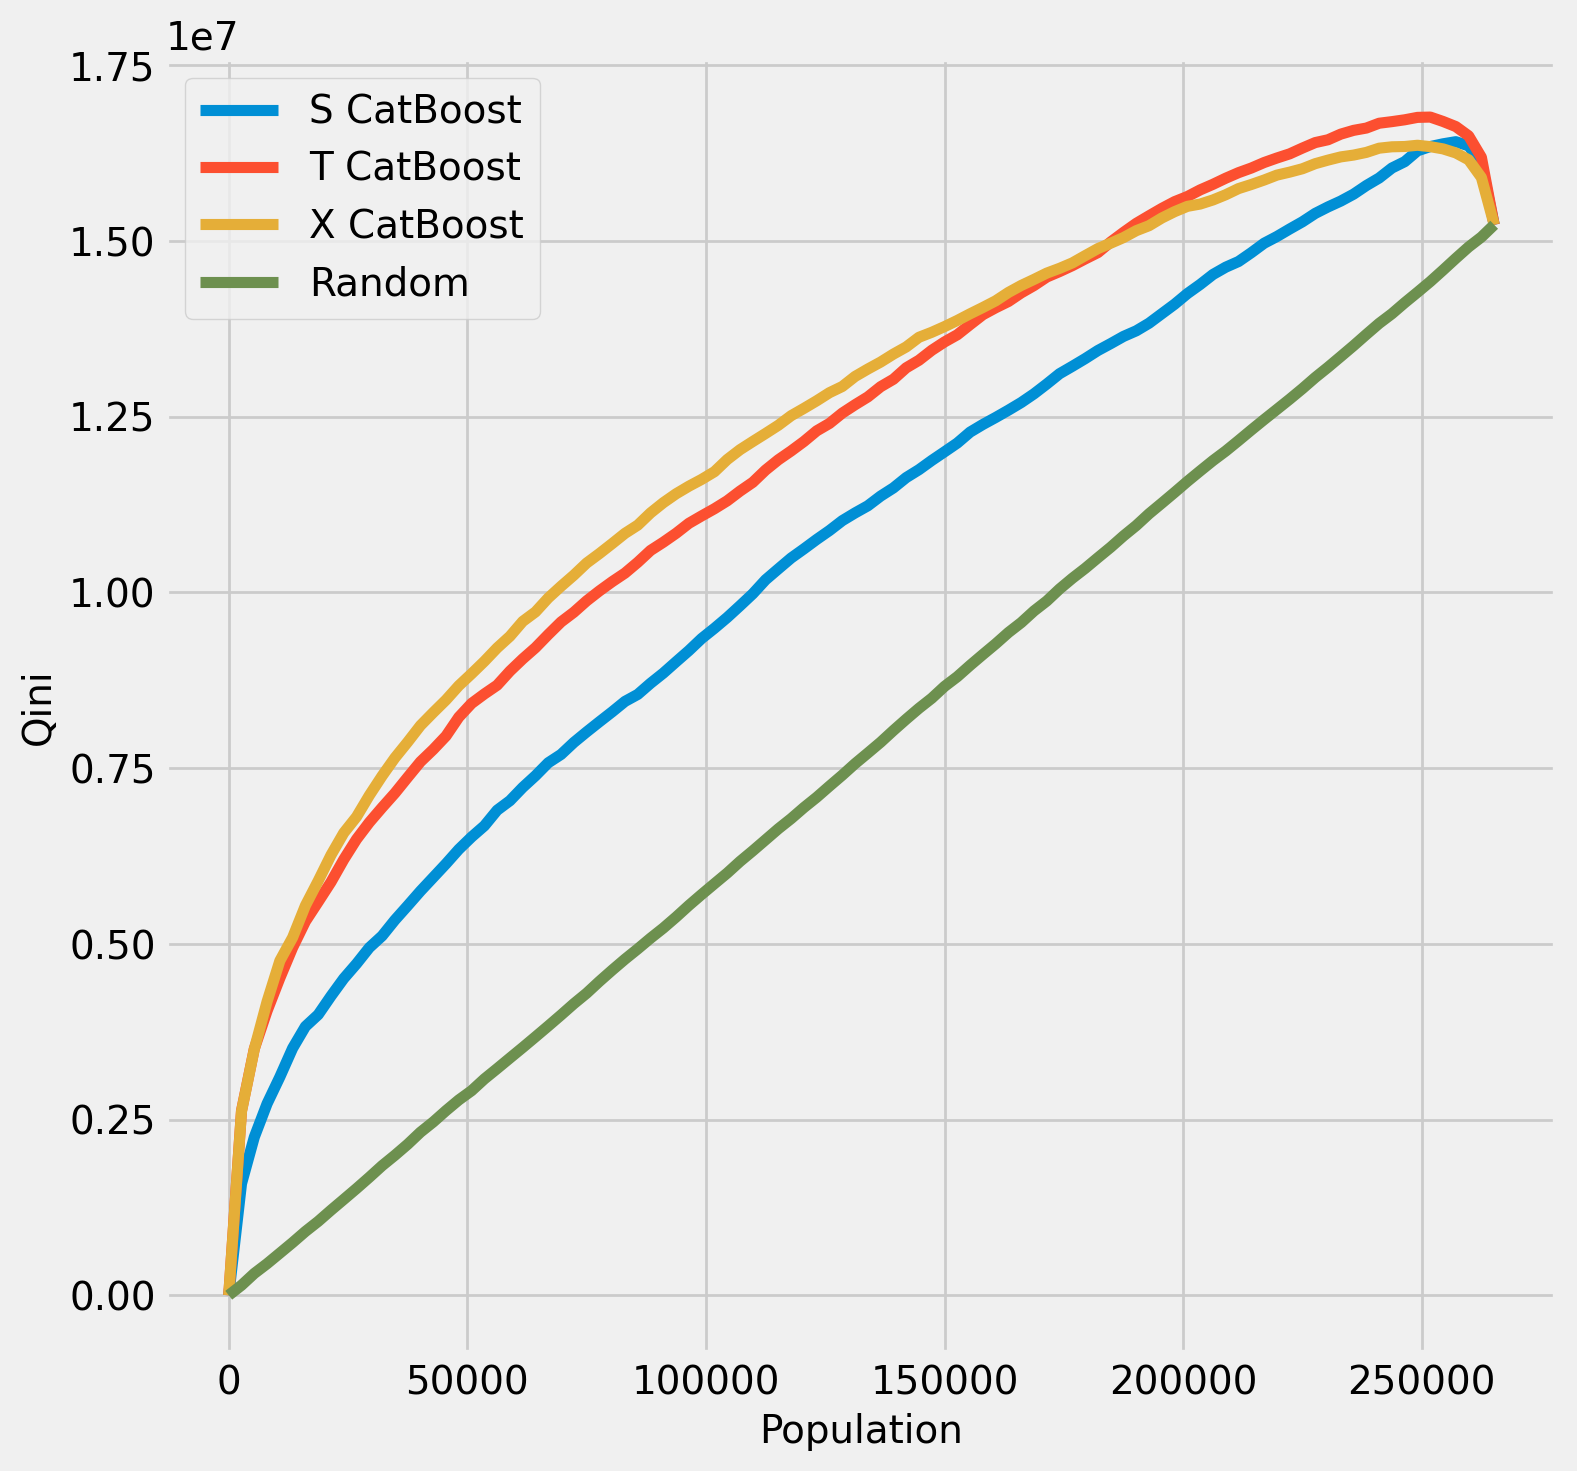

In [65]:
plot_qini(df_preds_catboost)

In [66]:
# S Learner with XGBoost searching hyperparameters

best_params_econml['S_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_s_xgboost = SLearner(overall_model=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                learner_s_xgboost.fit(X=X, T=treatment, Y=y)
                cate_s_xgboost = learner_s_xgboost.effect(X)
                df_preds_xgboost = pd.DataFrame([
                                   cate_s_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['S Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['S Xgboost']
                if cur_qini > best_qini:
                    best_params_econml['S_XGBoost']['n_estimators'] = n_estimators
                    best_params_econml['S_XGBoost']['max_depth'] = max_depth
                    best_params_econml['S_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for S_XGBoost:')
print(best_params_econml['S_XGBoost'])

100%|████████████████████████████████████████| 27/27 [1:21:11<00:00, 180.42s/it]

Best parameters for S_XGBoost:
{'n_estimators': 400, 'max_depth': 40, 'lr': 0.01}


In [67]:
# T Learner with XGBoost searching hyperparameters

best_params_econml['T_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_t_xgboost = TLearner(models=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                learner_t_xgboost.fit(X=X, T=treatment, Y=y)
                cate_t_xgboost = learner_t_xgboost.effect(X)
                df_preds_xgboost = pd.DataFrame([
                                   cate_t_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['T Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['T Xgboost']
                if cur_qini > best_qini:
                    best_params_econml['T_XGBoost']['n_estimators'] = n_estimators
                    best_params_econml['T_XGBoost']['max_depth'] = max_depth
                    best_params_econml['T_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for T_XGBoost:')
print(best_params_econml['T_XGBoost'])

100%|████████████████████████████████████████| 27/27 [1:16:09<00:00, 169.24s/it]

Best parameters for T_XGBoost:
{'n_estimators': 200, 'max_depth': 40, 'lr': 0.01}


In [68]:
# X Learner with XGBoost searching hyperparameters

best_params_econml['X_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_x_xgboost = XLearner(models=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                learner_x_xgboost.fit(X=X, T=treatment, Y=y)
                cate_x_xgboost = learner_x_xgboost.effect(X)
                df_preds_xgboost = pd.DataFrame([
                                   cate_x_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['X Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['X Xgboost']
                if cur_qini > best_qini:
                    best_params_econml['X_XGBoost']['n_estimators'] = n_estimators
                    best_params_econml['X_XGBoost']['max_depth'] = max_depth
                    best_params_econml['X_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for X_XGBoost:')
print(best_params_econml['X_XGBoost'])

100%|████████████████████████████████████████| 27/27 [2:29:21<00:00, 331.90s/it]

Best parameters for X_XGBoost:
{'n_estimators': 600, 'max_depth': 40, 'lr': 0.001}


In [69]:
learner_s_xgboost = SLearner(overall_model=XGBRegressor(n_estimators = best_params_econml['S_XGBoost']['n_estimators'], 
                                                        max_depth = best_params_econml['S_XGBoost']['max_depth'], 
                                                        learning_rate = best_params_econml['S_XGBoost']['lr'], gpu_id=1))
learner_s_xgboost.fit(X=X, T=treatment, Y=y)
cate_s_xgboost = learner_s_xgboost.effect(X)

print('S learner is fitted')


learner_t_xgboost = TLearner(models=XGBRegressor(n_estimators = best_params_econml['T_XGBoost']['n_estimators'], 
                                                max_depth = best_params_econml['T_XGBoost']['max_depth'], 
                                                learning_rate = best_params_econml['T_XGBoost']['lr'], gpu_id=1))
learner_t_xgboost.fit(X=X, T=treatment, Y=y)
cate_t_xgboost = learner_t_xgboost.effect(X)

print('T learner is fitted')

learner_x_xgboost = XLearner(models=XGBRegressor(n_estimators = best_params_econml['X_XGBoost']['n_estimators'], 
                                                max_depth = best_params_econml['X_XGBoost']['max_depth'], 
                                                learning_rate = best_params_econml['X_XGBoost']['lr'], gpu_id=1))
learner_x_xgboost.fit(X=X, T=treatment, Y=y)
cate_x_xgboost = learner_x_xgboost.effect(X)

print('X learner is fitted')

S learner is fitted
T learner is fitted
X learner is fitted


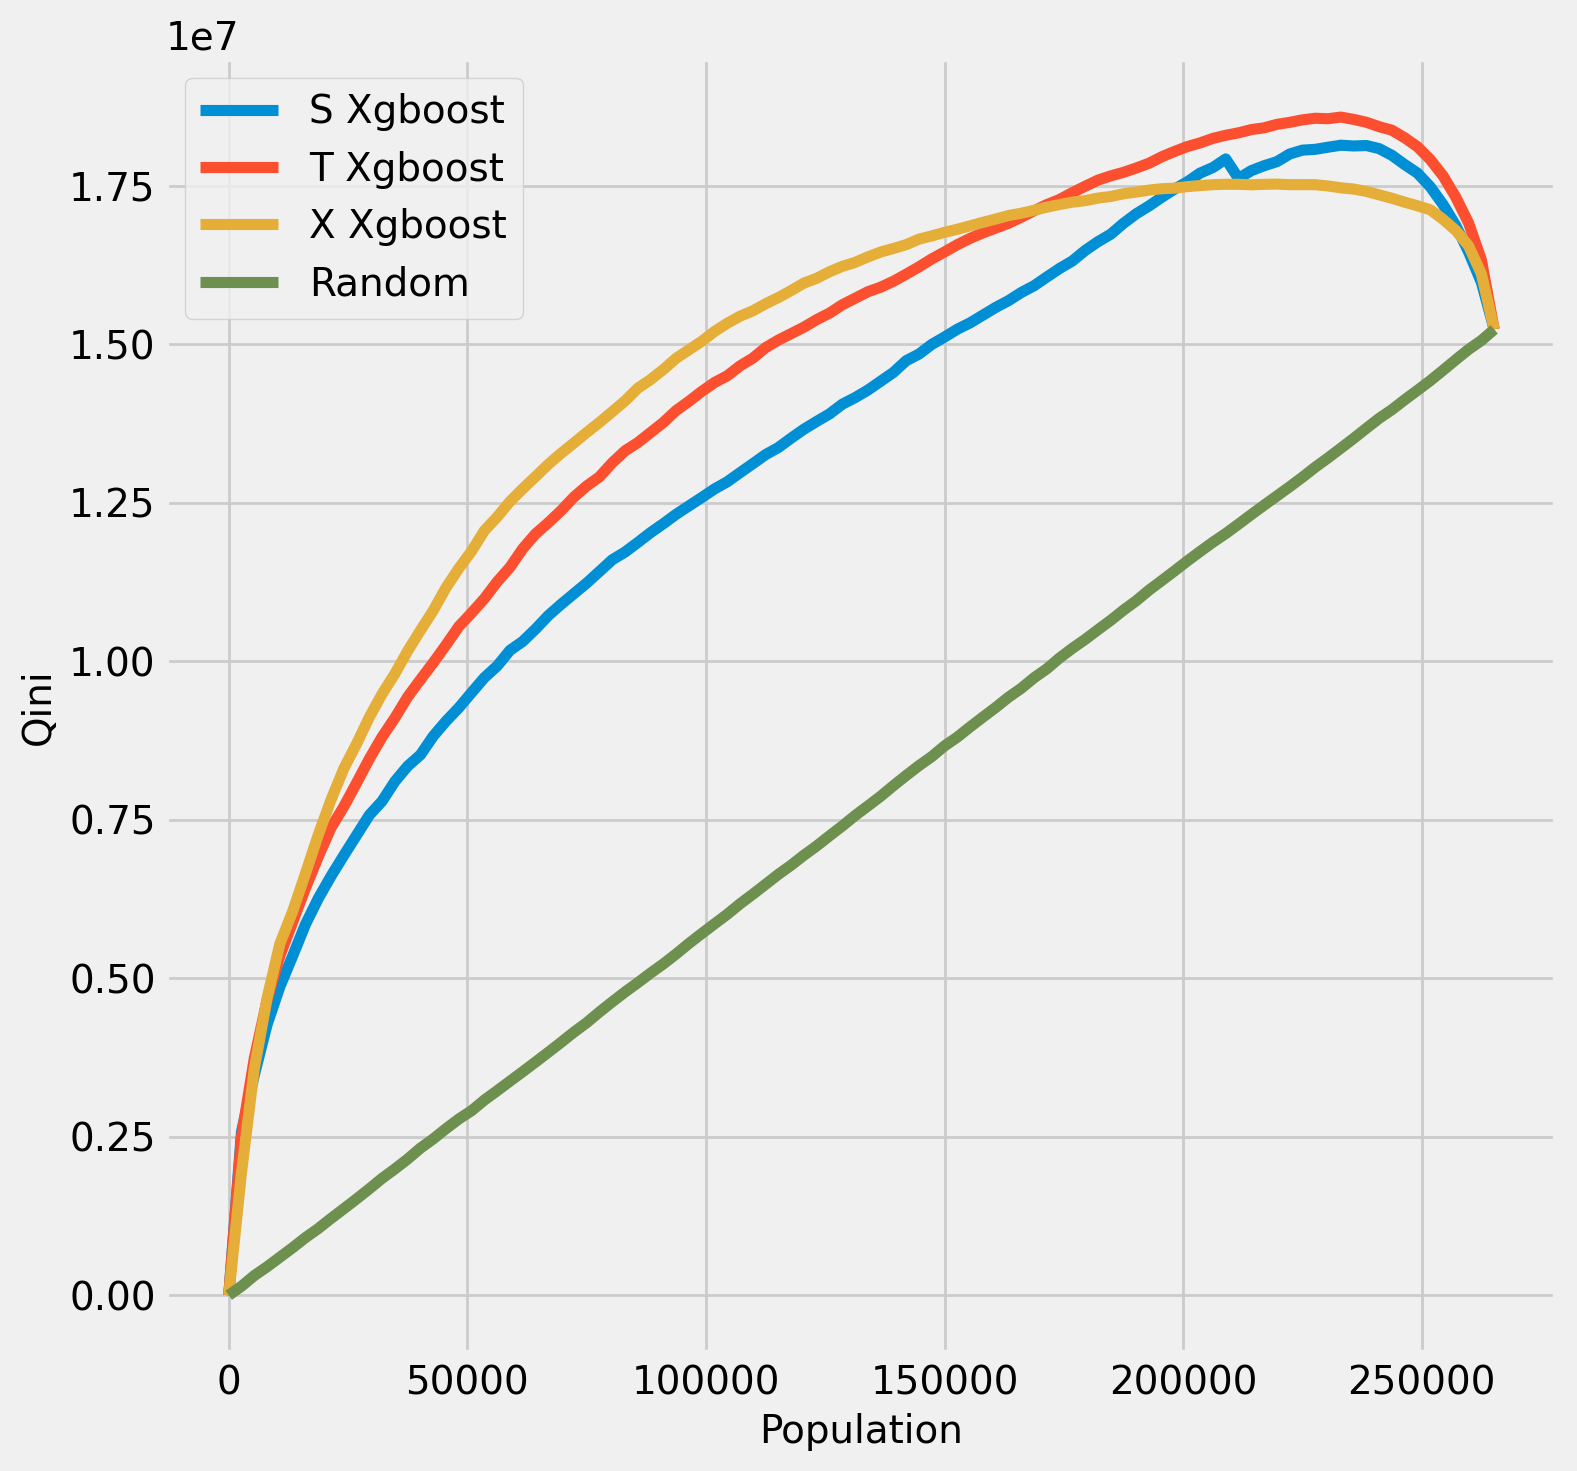

In [70]:
df_preds_xgboost = pd.DataFrame([
                   cate_s_xgboost.ravel(),
                   cate_t_xgboost.ravel(),
                   cate_x_xgboost.ravel(),
                   treatment.ravel(),
                   y.ravel()],
                   index=['S Xgboost', 'T Xgboost','X Xgboost','w','y']).T

plot_qini(df_preds_xgboost)

### MLP

In [71]:
from sklearn.neural_network import MLPRegressor

# S Learner with MLP searching hyperparameters

best_params_econml['S_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_s_mlp = SLearner(overall_model=MLPRegressor(hidden_layer_sizes = hls))    
        learner_s_mlp.fit(X=X, T=treatment, Y=y)
        cate_s_mlp = learner_s_mlp.effect(X)

        df_preds_mlp = pd.DataFrame([
                           cate_s_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['S MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['S MLP']
        if cur_qini > best_qini:
            best_params_econml['S_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for S_MLP:')
print(best_params_econml['S_MLP'])

100%|████████████████████████████████████████████| 6/6 [31:01<00:00, 310.20s/it]

Best parameters for S_MLP:
{'hls': [300, 300]}


In [72]:
best_params_econml['T_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_t_mlp = TLearner(models=MLPRegressor(hidden_layer_sizes = hls))    
        learner_t_mlp.fit(X=X, T=treatment, Y=y)
        cate_t_mlp = learner_t_mlp.effect(X)

        df_preds_mlp = pd.DataFrame([
                           cate_t_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['T MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['T MLP']
        if cur_qini > best_qini:
            best_params_econml['T_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for T_MLP:')
print(best_params_econml['T_MLP'])

100%|████████████████████████████████████████████| 6/6 [29:47<00:00, 297.86s/it]

Best parameters for T_MLP:
{'hls': [100]}


In [73]:
best_params_econml['X_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_x_mlp = XLearner(models=MLPRegressor(hidden_layer_sizes = hls))    
        learner_x_mlp.fit(X=X, T=treatment, Y=y)
        cate_x_mlp = learner_x_mlp.effect(X)

        df_preds_mlp = pd.DataFrame([
                           cate_x_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['X MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['X MLP']
        if cur_qini > best_qini:
            best_params_econml['X_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for X_MLP:')
print(best_params_econml['X_MLP'])

100%|████████████████████████████████████████████| 6/6 [58:55<00:00, 589.25s/it]

Best parameters for X_MLP:
{'hls': [200, 200]}


In [74]:
# S Learner on MLP

learner_s_mlp = SLearner(overall_model=MLPRegressor(hidden_layer_sizes = best_params_econml['S_MLP']['hls']))    
learner_s_mlp.fit(X=X, T=treatment, Y=y)
cate_s_mlp = learner_s_mlp.effect(X)

print('S Learner is fitted')

# T Learner on MLP

learner_t_mlp = TLearner(models=MLPRegressor(hidden_layer_sizes = best_params_econml['T_MLP']['hls']))    
learner_t_mlp.fit(X=X, T=treatment, Y=y)
cate_t_mlp = learner_t_mlp.effect(X)

print('T Learner is fitted')

# X Learner on MLP

learner_x_mlp = XLearner(models=MLPRegressor(hidden_layer_sizes = best_params_econml['X_MLP']['hls']))    
learner_x_mlp.fit(X=X, T=treatment, Y=y)
cate_x_mlp = learner_x_mlp.effect(X)

print('X Learner is fitted')

S Learner is fitted
T Learner is fitted
X Learner is fitted


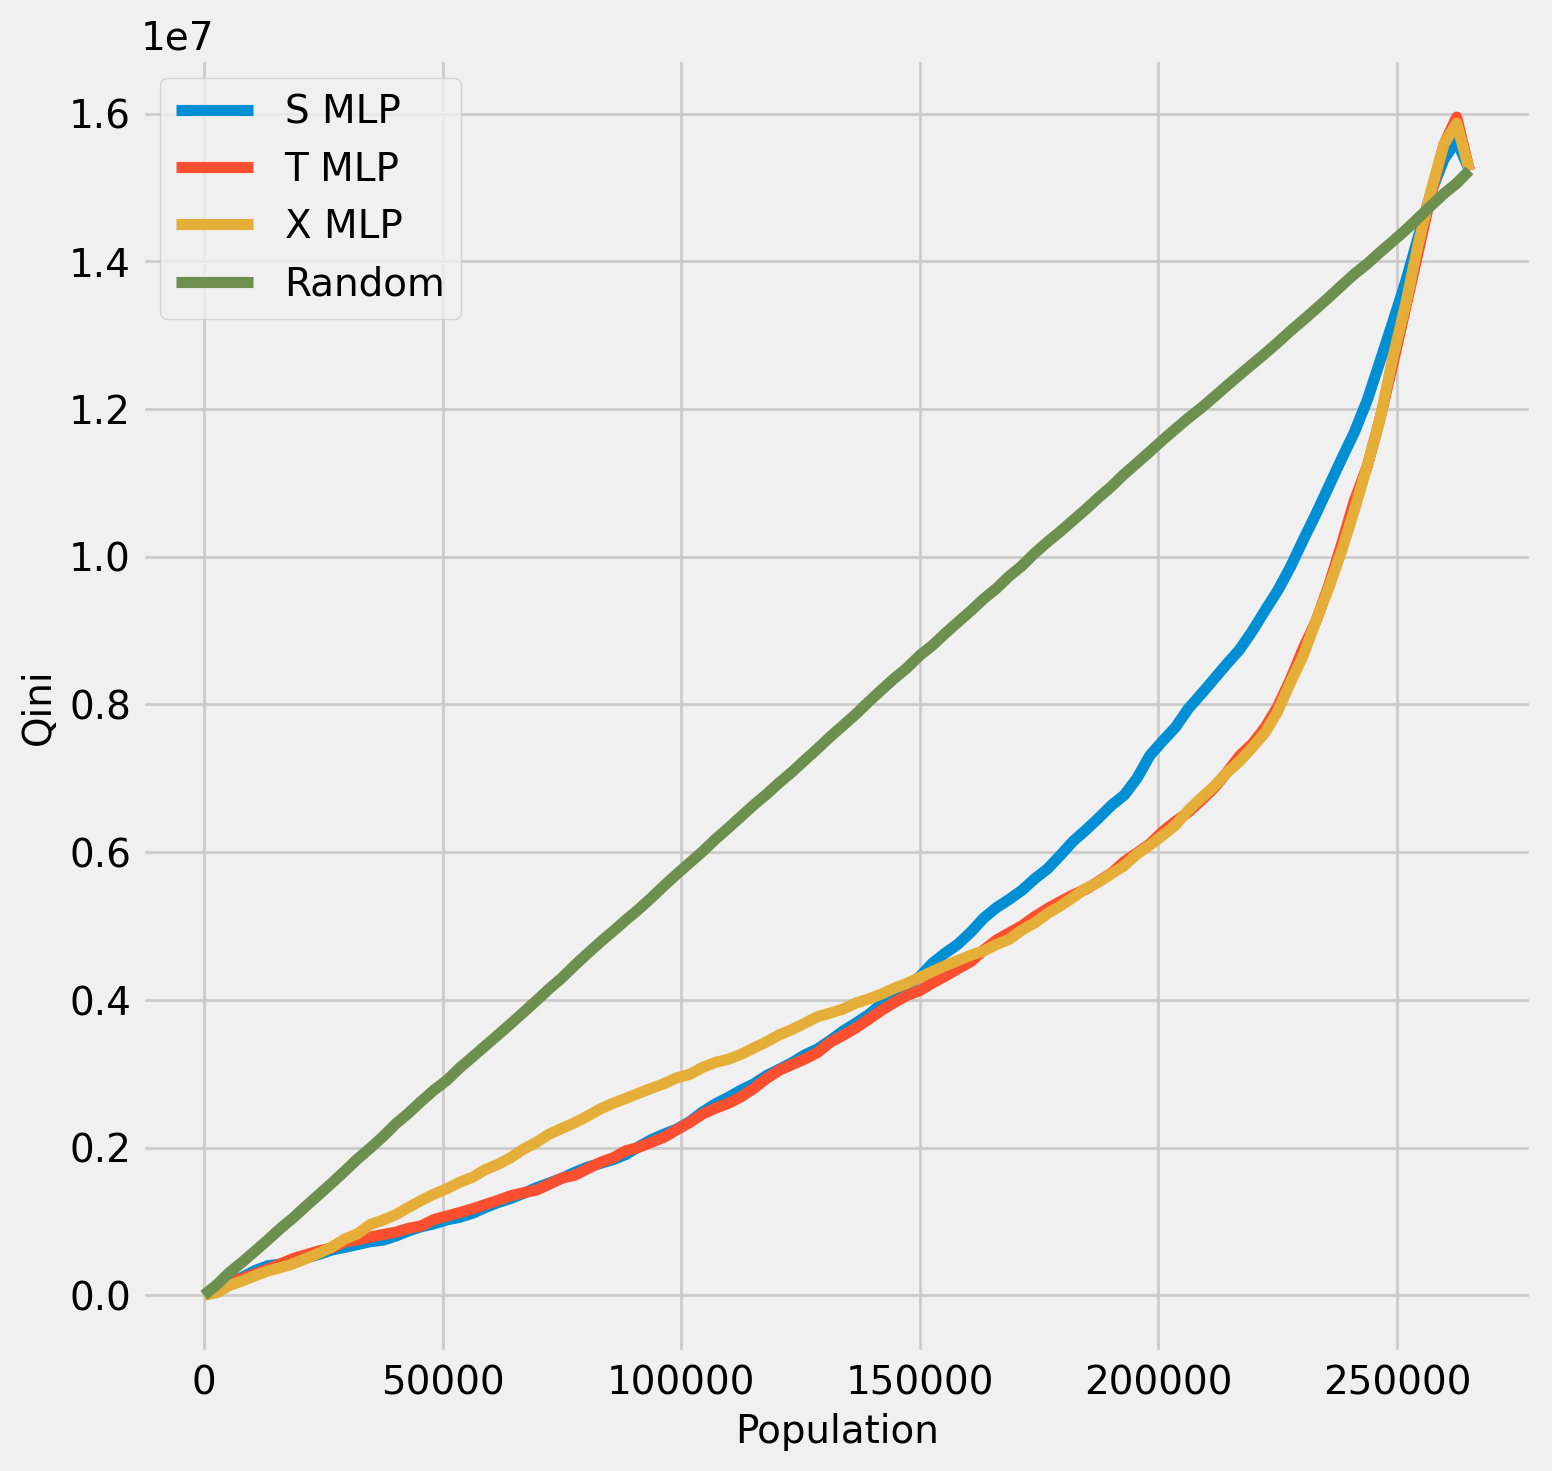

In [75]:
df_preds_mlp = pd.DataFrame([
                   cate_s_mlp.ravel(),
                   cate_t_mlp.ravel(),
                   cate_x_mlp.ravel(),
                   treatment.ravel(),
                   y.ravel()],
                   index=['S MLP', 'T MLP','X MLP','w','y']).T

plot_qini(df_preds_mlp)

In [92]:
best_params_econml

{'S_XGBoost': {'n_estimators': 600, 'max_depth': 60, 'lr': 0.01},
 'T_XGBoost': {'n_estimators': 400, 'max_depth': 40, 'lr': 0.01},
 'X_XGBoost': {'n_estimators': 200, 'max_depth': 40, 'lr': 0.01},
 'S_MLP': {'hls': [300, 300]},
 'T_MLP': {'hls': [100]},
 'X_MLP': {'hls': [300, 300]}}

### CTS

In [76]:
from econml.grf import CausalForest

best_params_econml['CTS_forest'] = {'max_depth': 0, 'n_estimators': 0}
best_qini = 0
with tqdm(total=12) as pbar:
    for max_depth in [5, 10, 20, 40]:
        for n_estimators in [8, 16, 32]:
            cforest = CausalForest(max_depth = max_depth, n_estimators=n_estimators, n_jobs=5)
            cate_forest = cforest.fit(X=X, y=y.values, T=treatment.values).predict(X=X)
            df_preds_forest = pd.DataFrame([
                               cate_forest.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['CTS_forest','w','y']).T
            cur_qini = get_qini(df_preds_forest).sum(axis=0)['CTS_forest']
            if cur_qini > best_qini:
                best_params_econml['CTS_forest']['max_depth'] = max_depth
                best_params_econml['CTS_forest']['n_estimators'] = n_estimators
                best_qini = cur_qini
            pbar.update(1)

                
print('Best parameters for CTS_forest:')
print(best_params_econml['CTS_forest'])


100%|███████████████████████████████████████████| 12/12 [00:52<00:00,  4.40s/it]

Best parameters for CTS_forest:
{'max_depth': 40, 'n_estimators': 8}


In [77]:
cforest = CausalForest(max_depth = best_params_econml['CTS_forest']['max_depth'], 
                       n_estimators = best_params_econml['CTS_forest']['n_estimators'], n_jobs=5)
cate_forest = cforest.fit(X=X, y=y.values, T=treatment.values).predict(X=X)

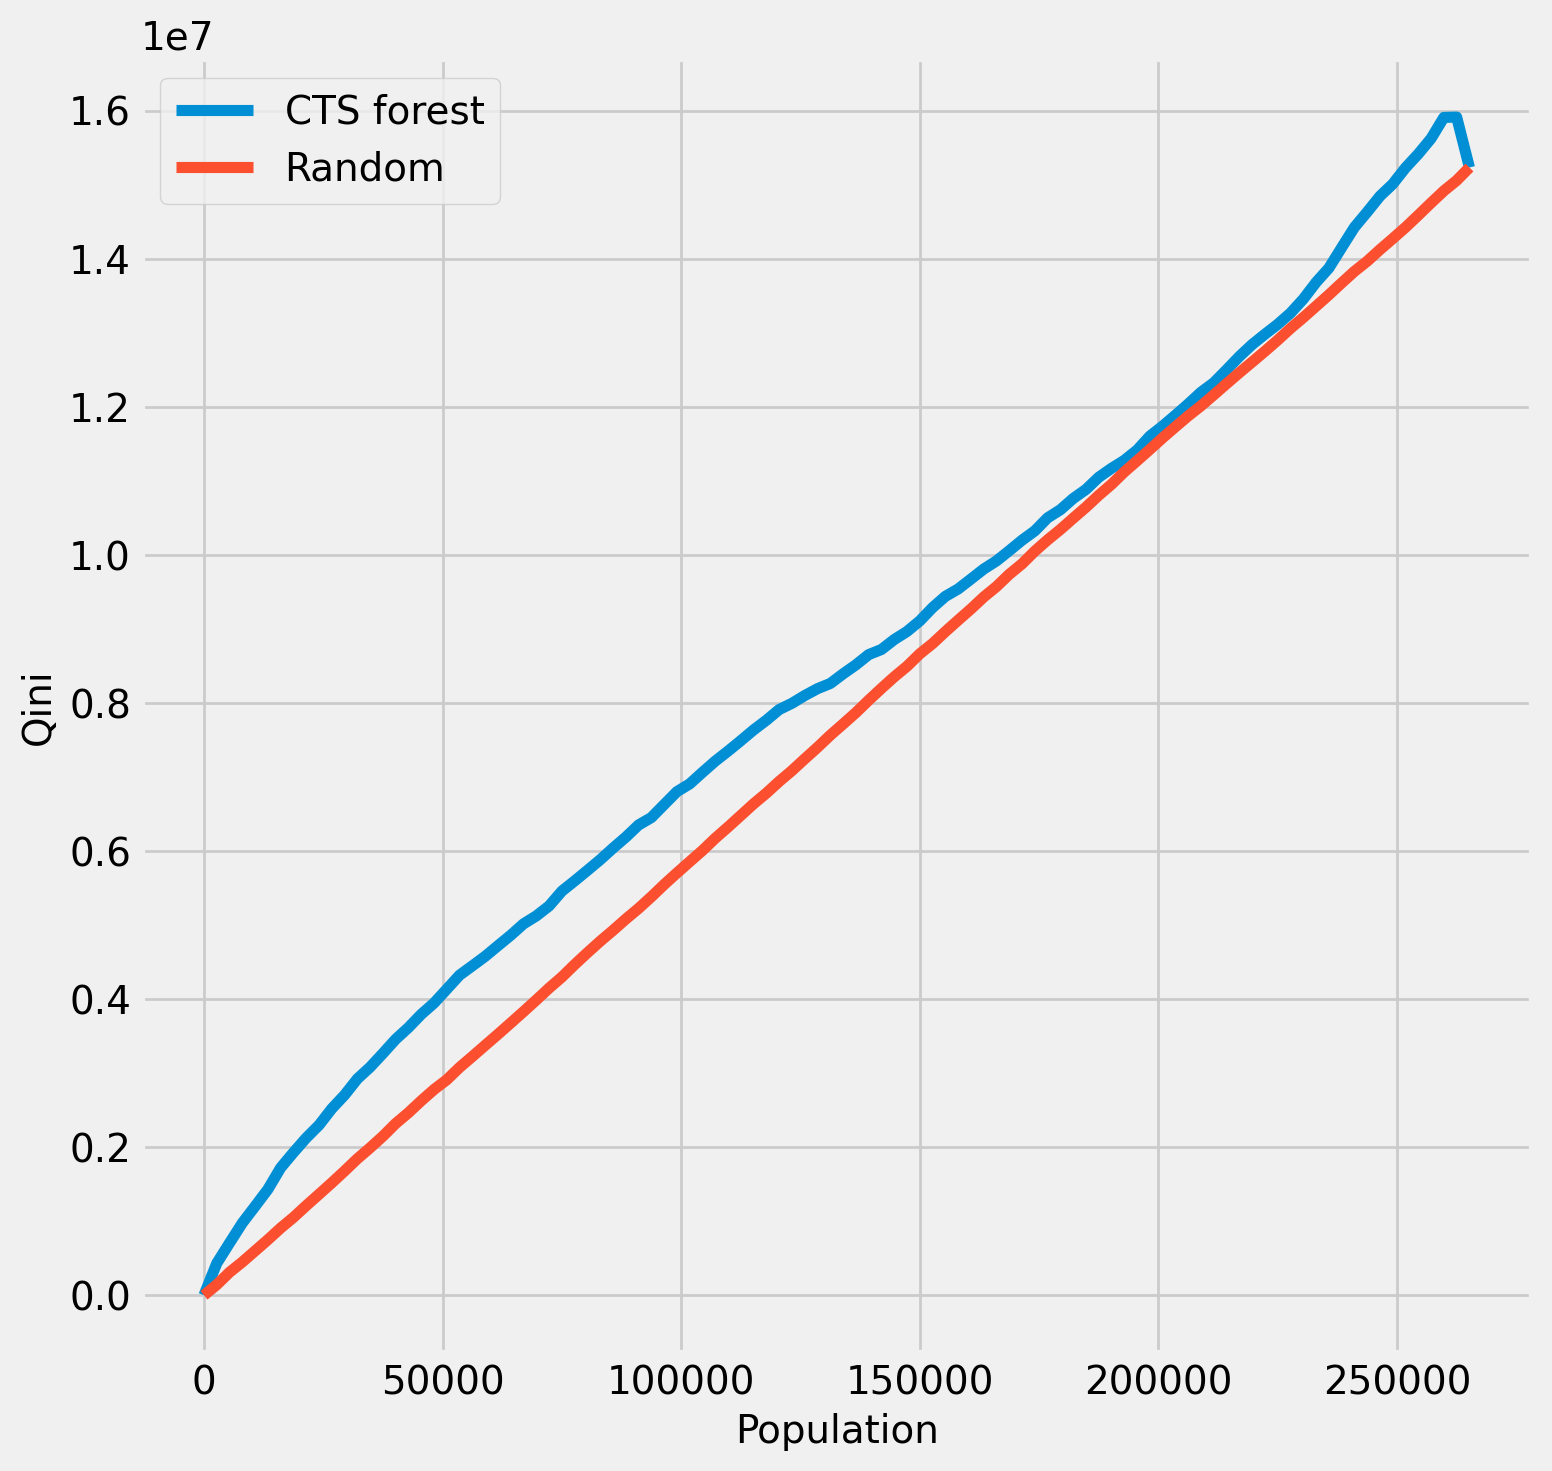

In [78]:
df_preds_cts = pd.DataFrame([  cate_forest.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['CTS forest','w','y']).T

plot_qini(df_preds_cts)

In [79]:
best_params_econml

{'S_CatBoost': {'iterations': 600, 'depth': 16, 'lr': 0.1},
 'T_CatBoost': {'iterations': 600, 'depth': 16, 'lr': 0.1},
 'X_CatBoost': {'iterations': 600, 'depth': 16, 'lr': 0.1},
 'S_XGBoost': {'n_estimators': 400, 'max_depth': 40, 'lr': 0.01},
 'T_XGBoost': {'n_estimators': 200, 'max_depth': 40, 'lr': 0.01},
 'X_XGBoost': {'n_estimators': 600, 'max_depth': 40, 'lr': 0.001},
 'S_MLP': {'hls': [300, 300]},
 'T_MLP': {'hls': [100]},
 'X_MLP': {'hls': [200, 200]},
 'CTS_forest': {'max_depth': 40, 'n_estimators': 8}}

In [80]:
df_preds_econml = pd.DataFrame([cate_s_catboost.ravel(),
                                cate_t_catboost.ravel(),
                                cate_x_catboost.ravel(),
                                cate_s_xgboost.ravel(),
                                cate_t_xgboost.ravel(),
                                cate_x_xgboost.ravel(),
                                cate_s_mlp.ravel(),
                                cate_t_mlp.ravel(),
                                cate_x_mlp.ravel(),
                                cate_forest.ravel(),
                                treatment.ravel(),
                                y.ravel()],
                                index=['S CatBoost', 'T CatBoost', 'X CatBoost', 'S XGBoost', 'T XGBoost', 'X XGBoost', 'S MLP', 'T MLP', 'X MLP', 'CTS_forest','w','y']).T
qini_coeff = get_qini(df_preds_econml).sum(axis=0)
qini_coeff

S CatBoost    2.819787e+12
T CatBoost    3.199669e+12
X CatBoost    3.245900e+12
S XGBoost     3.544060e+12
T XGBoost     3.816367e+12
X XGBoost     3.852631e+12
S MLP         1.275415e+12
T MLP         1.177970e+12
X MLP         1.233368e+12
CTS_forest    2.206507e+12
Random        2.021220e+12
dtype: float64